# Spike to Spike Regression: Oxford

This tutorial demonstrates _spike to spike regression_ training using __`lava.lib.dl.slayer`__.

The task is to learn to transform a random Poisson spike train to produce output spike pattern that resembles _The Radcliffe Camera_ building of Oxford University, England. The input and output both consist of 200 neurons each and the spikes span approximately 1900ms. The input and output pair are converted from [SuperSpike](https://github.com/fzenke/pub2018superspike) (© GPL-3).

<table>
<tr>
    <td align="center"><b>Input</b></td>
    <td align="center"><b>Target</b></td>
</tr><tr>
    <td> <img src="input.gif" alt="Drawing" style="height: 400px;"/> </td>
    <td> <img src="target.gif" alt="Drawing" style="height: 400px"/> </td>
</tr>
</table>

In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

# import slayer from lava-dl
import lava.lib.dl.slayer as slayer

import IPython.display as display
from matplotlib import animation

# Create Dataset

Create a simple PyTorch dataset class. The dataset class follows standard torch dataset definition.

It shows usage of __`slayer.io`__ module. The module provides a way to 

* easily represent events including graded spikes
* read/write events in different known binary and numpy formats
* transform event to tensor for processing it using slayer network and convert a spike tensor back to event
* display/animate the tensor for visualization

In [2]:
class OxfordDataset(Dataset):
    def __init__(self):
        super(OxfordDataset, self).__init__()
        self.input  = slayer.io.read_1d_spikes('input.bs1' )
        self.target = slayer.io.read_1d_spikes('output.bs1')
        self.target.t = self.target.t.astype(int)

    def __getitem__(self, _):
        return (
            self.input.fill_tensor(torch.zeros(1, 1, 200, 2000)).squeeze(),  # input
            self.target.fill_tensor(torch.zeros(1, 1, 200, 2000)).squeeze(), # target
        )

    def __len__(self):
        return 1 # just one sample for this problem

# Create Network

A slayer network definition follows standard PyTorch way using `torch.nn.Module`.

The network can be described with a combination of individual `synapse`, `dendrite`, `neuron` and `axon` components. For rapid and easy development, slayer provides __block interface__ - `slayer.block` - which bundles all these individual components into a single unit. These blocks can be cascaded to build a network easily. The block interface provides additional utilities for normalization (weight and neuron), dropout, gradient monitoring and network export.

In the example below, `slayer.block.cuba` is illustrated.

In [3]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        neuron_params = {
                'threshold'     : 0.1,
                'current_decay' : 1,
                'voltage_decay' : 0.1,
                'requires_grad' : True,     
            }
        
        self.blocks = torch.nn.ModuleList([
                slayer.block.cuba.Dense(neuron_params, 200, 256),
                slayer.block.cuba.Dense(neuron_params, 256, 200),
            ])
    
    def forward(self, spike):
        for block in self.blocks:
            spike = block(spike)
        return spike

    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

# Instantiate Network, Optimizer, DataSet and DataLoader

Running the network in GPU is as simple as selecting `torch.device('cuda')`.

In [4]:
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

# device = torch.device('cpu')
device = torch.device('cuda') 

net = Network().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

training_set = OxfordDataset()
train_loader = DataLoader(dataset=training_set, batch_size=1)

# Visualize the input and output spike train

A `slayer.io.Event` can be visualized by invoking it's `Event.show()` routine. `Event.anim()` instead returns the event visualization animation which can be embedded in notebook or exported as video/gif. Here, we will export gif animation and visualize it.

In [5]:
input_anim  = training_set.input.anim(plt.figure(figsize=(10, 10)))
target_anim = training_set.target.anim(plt.figure(figsize=(10, 10)))

## This produces interactive animation
# display.HTML(input_anim.to_jshtml())
# display.HTML(target_anim.to_jshtml())

## Saving and loading gif for better animation in github
input_anim.save('input.gif', animation.PillowWriter(fps=24), dpi=300)
target_anim.save('target.gif', animation.PillowWriter(fps=24), dpi=300)

In [6]:
gif_td = lambda gif: f'<td> <img src="{gif}" alt="Drawing" style="height: 400px;"/> </td>'
html = '<table><tr>'
html += '<td> Input </td><td> Target </td></tr><tr>'
html += gif_td(f'input.gif')
html += gif_td(f'target.gif')
html += '</tr></table>'
display.HTML(html)


Input,Target
,


# Error module

Slayer provides prebuilt loss modules: `slayer.loss.{SpikeTime, SpikeRate, SpikeMax}`.
* `SpikeTime`: precise spike time based loss when target spike train is known.
* `SpikeRate`: spike rate based loss when desired rate of the output neuron is known.
* `SpikeMax`: negative log likelihood losses for classification without any rate tuning.

Since the target spike train $\hat{\boldsymbol s}(t)$ is known for this problem, we use `SpikeTime` loss here. It uses _van Rossum_ like spike train distance metric. The actual and target spike trains are filtered using a FIR filter and the norm of the timeseries is the loss metric.

$$L = \frac{1}{2T} \int_T \left(h_\text{FIR} * ({\boldsymbol s} - \hat{\boldsymbol s})\right)(t)^\top{\bf 1}\,\text dt $$

* `time_constant`: time constant of the FIR filter.
* `filter_order`: the order of FIR filter. Exponential decay is first order filter.

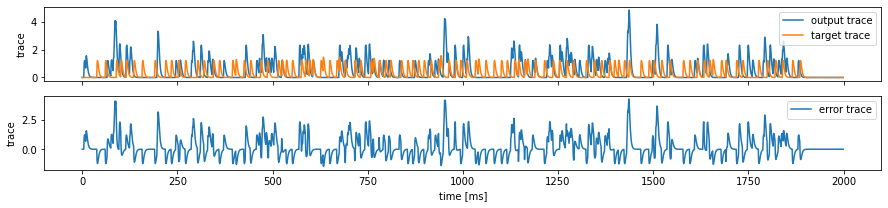

In [7]:
error = slayer.loss.SpikeTime(time_constant=2, filter_order=2).to(device)

# the followng portion just illustrates the SpikeTime loss calculation. 
# IT IS NOT NEEDED IN PRACTICE
input, target = training_set[0]
output = net(input.unsqueeze(dim=0).to(device))[0]
# just considering first neuron for illustration
output_trace = error.filter(output[0].to(device)).flatten().cpu().data.numpy()
target_trace = error.filter(target[0].to(device)).flatten().cpu().data.numpy()
fig, ax = plt.subplots(2, 1, figsize=(15, 3), sharex=True)
ax[0].plot(output_trace, label='output trace')
ax[0].plot(target_trace, label='target trace')
ax[1].plot(output_trace - target_trace, label='error trace')
ax[0].set_ylabel('trace')
ax[1].set_ylabel('trace')
ax[1].set_xlabel('time [ms]')
for a in ax: a.legend()

# Stats and Assistants

Slayer provides `slayer.utils.LearningStats` as a simple learning statistics logger for training, validation and testing.

In addtion, `slayer.utils.Assistant` module wraps common training validation and testing routine which help simplify the training routine.

In [8]:
stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(net, error, optimizer, stats)

# Training Loop

Training loop mainly consists of looping over epochs and calling `assistant.train` utility to train.

* `stats` can be used in print statement to get formatted stats printout.
* `stats.training.best_loss` can be used to find out if the current iteration has the best loss. Here, we use it to save the best model.
* `stats.update()` updates the stats collected for the epoch.
* `stats.save` saves the stats in files.

In [9]:
epochs = 5000

for epoch in range(epochs):
    for i, (input, target) in enumerate(train_loader): # training loop
        output = assistant.train(input, target)
        print(f'\r[Epoch {epoch:3d}/{epochs}] {stats}', end='')
    
    if stats.training.best_loss:
        torch.save(net.state_dict(), trained_folder + '/network.pt')
    stats.update()
    stats.save(trained_folder + '/')

[Epoch 4999/5000] Train loss = 46478.09375 (min = 44918.71875))

# Plot the learning curves

Plotting the learning curves is as easy as calling `stats.plot()`.

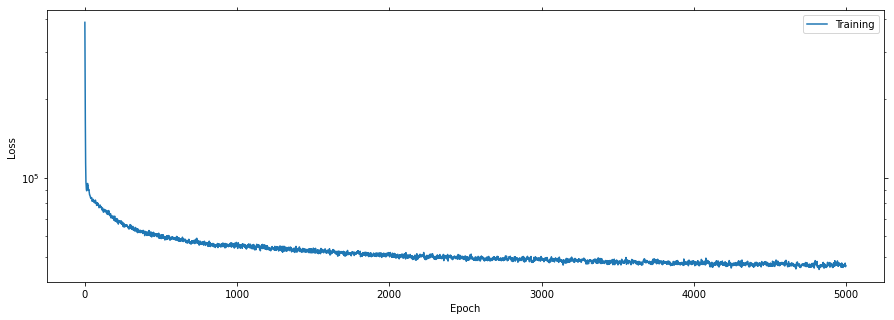

In [10]:
stats.plot(figsize=(15, 5))

# Export the best model

Load the best model during training and export it as hdf5 network. It is supported by `lava.lib.dl.netx` to automatically load the network as a lava process.

In [11]:
net.load_state_dict(torch.load(trained_folder + '/network.pt'))
net.export_hdf5(trained_folder + '/network.net')

# Visualize the network output

Here, we will use `slayer.io.tensor_to_event` method to convert the torch output spike tensor into `slayer.io.Event` object and visualize the input and output event.

In [12]:
output = net(input.to(device))
event = slayer.io.tensor_to_event(output.cpu().data.numpy())
output_anim = event.anim(plt.figure(figsize=(10, 10)))
# display.HTML(output_anim.to_jshtml())
output_anim.save('output.gif', animation.PillowWriter(fps=24), dpi=300)

html = '<table><tr>'
html += '<td>Output</td><td>Target</td></tr><tr>'
html += gif_td(f'output.gif')
html += gif_td(f'target.gif')
html += '</tr></table>'
display.HTML(html)

Output,Target
,


# Compare Output vs Target

Event data can be accessed as `slayer.io.Event.{x, y, c, t, p}` for x-address, y-address, channel-address, timestamp and graded-payload. This can be used for further processing and visualization of event data.

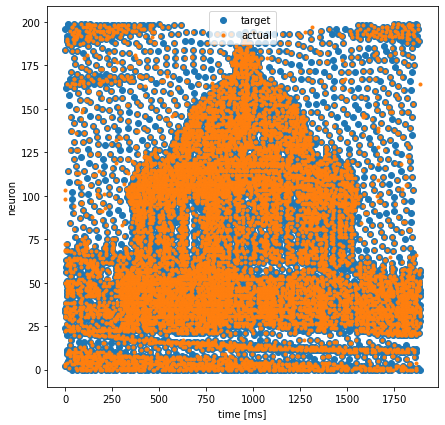

In [13]:
plt.figure(figsize=(7, 7))
plt.plot(training_set.target.t, training_set.target.x, '.', markersize=12, label='target')
plt.plot(event.t, event.x, '.', label='actual')
plt.xlabel('time [ms]')
plt.ylabel('neuron')
plt.legend()